# Introductory notes

Supplementary code to the article

Compositions of fractionated boninite series melts from the Izu-Bonin-Mariana arc by

Valetich, Le Losq, Arculus, Umino and Mavrogenes

## Requires

Python 3.6 or higher
pandas
matplotlib
numpy
sklearn


# Library Importation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

# to impute missing values
from sklearn import impute#SimpleImputer, MissingIndicator

# to pre-process the data => standardization
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture as GM
from sklearn.cluster import KMeans
from sklearn import metrics

# to make blobs
from sklearn.datasets import make_blobs, make_gaussian_quantiles

# to train/test split
from sklearn.model_selection import train_test_split

# local library
import boninites

# Starting example

This is the code generating the example shown in figure 4.

For this example, we use a fack dataset that corresponds to a mixture of 2 Gaussian distributions. The X values could be, for instance, two elements for chemical composition, and Y values will be the labels (e.g. high silica or low silica boninites).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


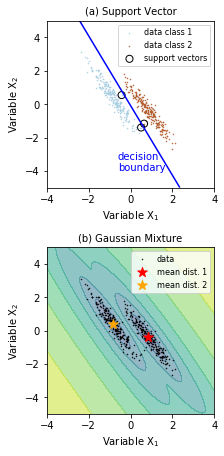

In [2]:
n_samples = 500
random_state = 170
X_, y_ = make_blobs(n_samples=n_samples, centers=2, random_state=random_state)

transformation = [[1.5, -1.5], [-0.3, 0.9]]
X_ = np.dot(X_, transformation)

# train/test splitting
X_train, X_test, y_train, y_test = train_test_split(X_,y_,test_size = 0.1,random_state=42)

# standardization: StandardScaler from sklearn
# see https://scikit-learn.org/stable/modules/preprocessing.html
scaler = preprocessing.StandardScaler().fit(X_train)

# we apply the scaler on both the training and testing sets
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# training the Support Vector Classifier with a linear kernel
clf = svm.SVC(C=100,kernel='linear',random_state=42)
clf.fit(X_train_sc, y_train) 

# predicting test values
y_pred_test = clf.predict(X_test_sc)
y_pred_train = clf.predict(X_train_sc)

# Simple Gaussian Mixture model
model_BGM = GM(n_components=2,random_state=42)
model_BGM.fit(X_train_sc) 

#= plt.figure(figsize=(3.22,6.45))

fig, (ax,ax2) = plt.subplots(2,1,figsize=(3.22, 6.44))

# plot data
ax.scatter(X_train_sc[y_train==0, 0], X_train_sc[y_train==0, 1], 
           marker=".",s=1, c=plt.cm.Paired.colors[0],label="data class 1")
ax.scatter(X_train_sc[y_train==1, 0], X_train_sc[y_train==1, 1], 
           marker=".",s=1, c=plt.cm.Paired.colors[-1],label="data class 2")


# plot the decision function
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(-5, 5, 200)
yy = np.linspace(-5, 5, 200)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='blue', levels=[0], alpha=1,
           linestyles=['-'])

# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=50,
           linewidth=1, facecolors='none', edgecolors='k',label="support vectors")

# Subplot 2 : GM


Z_G = -model_BGM.score_samples(xy).reshape(XX.shape)

from matplotlib import cm
from matplotlib.colors import LogNorm
ax2.contourf(XX, YY, Z_G, norm=LogNorm(vmin=.1, vmax=1000.0),
                 levels=np.logspace(-1, 5, 15),alpha=0.5)

ax2.scatter(X_train_sc[:, 0], X_train_sc[:, 1], 
            marker=".",s=1,c="black", alpha=1,label="data")
#import matplotlib as mpl
#colors = [plt.cm.Paired.colors[0], plt.cm.Paired.colors[-1]]
#make_ellipses(model_BGM,ax2)

ax.set_xlabel(r"Variable X$_1$")
ax.set_ylabel(r"Variable X$_2$")
ax2.set_xlabel(r"Variable X$_1$")
ax2.set_ylabel(r"Variable X$_2$")

ax.set_xlim(-4,4)
ax.set_ylim(-5,5)
ax2.set_xlim(-4,4)
ax2.set_ylim(-5,5)

ax.set_title("(a) Support Vector",fontsize=10)
ax2.set_title("(b) Gaussian Mixture",fontsize=10)


plt.draw()
ax2.scatter(model_BGM.means_[0,0],model_BGM.means_[0,1],marker="*",color="red",s=100,label="mean dist. 1")
ax2.scatter(model_BGM.means_[1,0],model_BGM.means_[1,1],marker="*",color="orange",s=100,label="mean dist. 2")

ax.annotate("decision\nboundary",xy=(-.6,-4),xycoords="data",color="blue")
plt.draw()

ax.legend(fontsize=8)   
ax2.legend(fontsize=8,frameon=True)

plt.tight_layout()

plt.savefig("./Results/figures/Figure4.pdf")

# Importing training data with Pandas

In [3]:
df_training = pd.read_csv("./data/HighLowSiDatabase.csv")
df_MV = pd.read_csv("./data/MV_Glass.csv")
df_352 = pd.read_csv("./data/352_Glass.csv")
df_all = pd.read_csv("./data/ALLBoniniteDatabase.csv",na_values="N.M.")

# MgO-SiO2 Support Vector Classification

In [4]:
# elements of interest
elements=["SiO2","MgO"]

# variable assignements
X_ori = df_training.loc[:,elements]
y_ = df_training.loc[:,"label"]

# data imputation. We then need to impute (replace NaN) missing data. 
# We replace them by the mean value of the column. We also need to check how many of them we have. 
# Results will be reasonable if we have less than 5 %.
imp_mean = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
X_ = imp_mean.fit_transform(X_ori)

# test
print("Is there NaN left? "+str(np.isnan(np.sum(X_))))

# train/test splitting
X_train, X_test, y_train, y_test = train_test_split(X_,y_,test_size = 0.3,random_state=42)

# standardization: StandardScaler from sklearn
# see https://scikit-learn.org/stable/modules/preprocessing.html
scaler = preprocessing.StandardScaler().fit(X_train)

# we apply the scaler on both the training and testing sets
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# training the Support Vector Classifier with a linear kernel
clf = svm.SVC(C=100,kernel='linear',random_state=42)
clf.fit(X_train_sc, y_train) 

# predicting test values
y_pred_test = clf.predict(X_test_sc)
y_pred_train = clf.predict(X_train_sc)

# Model Accuracy: how often is the classifier correct?
print("\nAccuracy on train: %.2f" % (metrics.accuracy_score(y_train, y_pred_train)*100,))
print("Accuracy on testing: %.2f" % (metrics.accuracy_score(y_test, y_pred_test)*100,))

W = clf.coef_
b = clf.intercept_
print('\nweights W: ')
print(W)
print('Intercept b: ')
print(b)

Is there NaN left? False

Accuracy on train: 85.29
Accuracy on testing: 86.36

weights W: 
[[1.71647643 1.91462244]]
Intercept b: 
[0.49969313]


Separating hyperplane equation is of the form

$W0 \times [SiO2] + W1 \ times [MgO] + b = 0$

so taking the data standardization into account, the separating line in the MgO-SiO$_2$ plot can be expressed as:

$ [MgO]^{separation} = ((-1.7164\times (\frac{([SiO2]-55.2519)}{2.4599}) - 0.4996)/1.9146)\times 3.527464 + 14.0039$

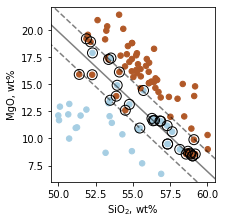

In [5]:
plt.figure(figsize=(3.22,3.22))

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(scaler.transform(xy)).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# plot support vectors
ax.scatter(scaler.inverse_transform(clf.support_vectors_)[:, 0], scaler.inverse_transform(clf.support_vectors_)[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.xlabel(elements[0]+", wt%")
plt.ylabel(elements[1]+", wt%")

plt.xlabel(r"SiO$_2$, wt%")
plt.tight_layout()

plt.savefig("./Results/figures/Result_SVM_MgOSiO2.pdf")

# Gaussian Mixture unsupervised learning

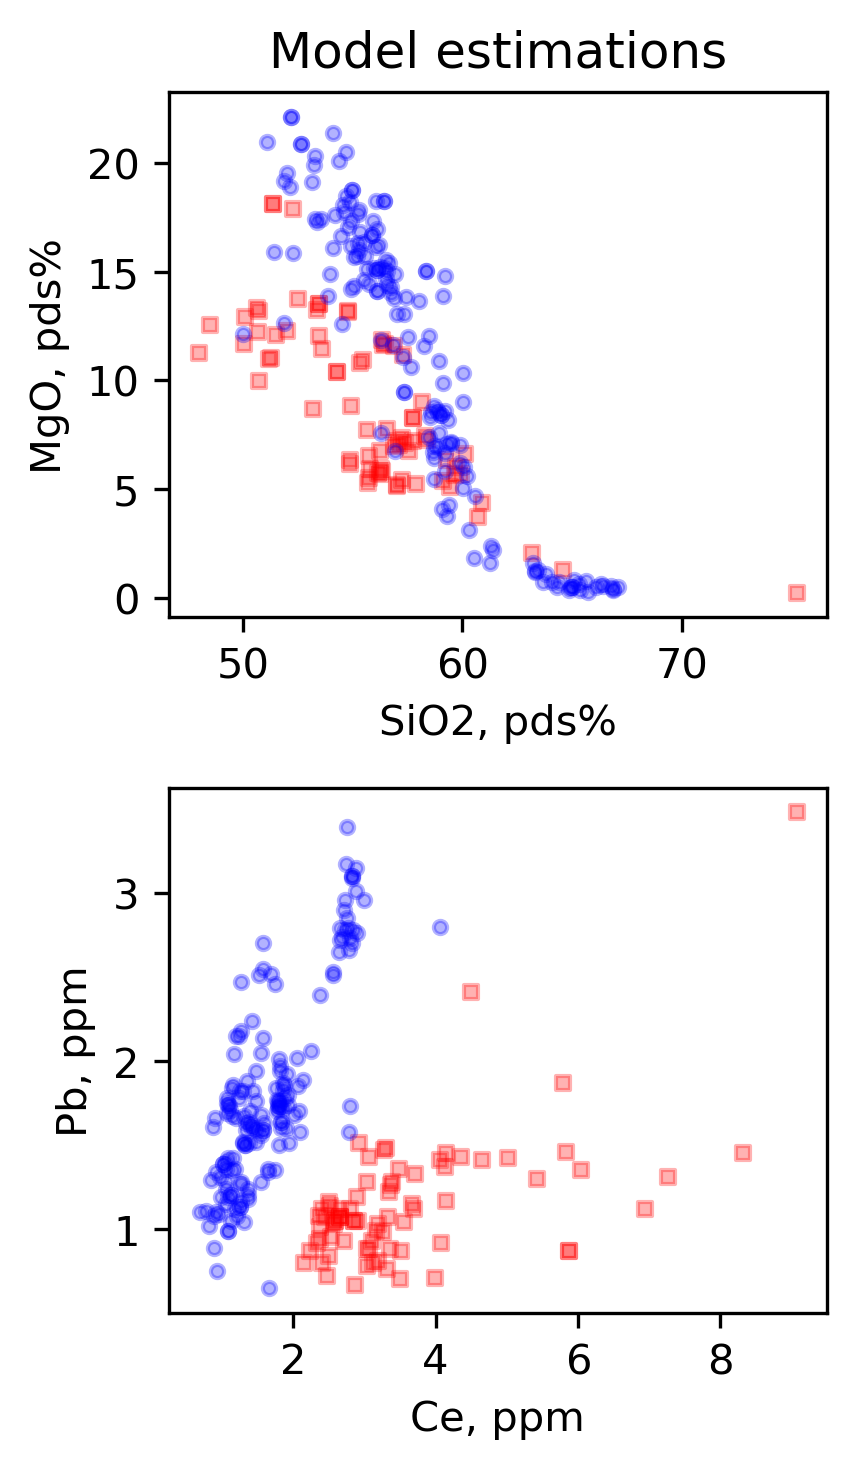

In [6]:
# Simple Gaussian Mixture model
model_BGM = GM(n_components=2,random_state=42)

# Note that K-mean clustering could also provide interesting results
# We thus leave the possibility to train a K-mean model there.
model_Kmean = KMeans(init='k-means++', n_clusters=2, n_init=10,random_state=42)

elements_to_train = ["Rb","Lu"]
training_boninite = boninites.boninite(model_BGM,df_all,elements_to_train)
training_boninite.fit()
predict_df_all = training_boninite.predict(df_all) 

plt.figure(figsize=(3,5),dpi=300)

elements_plot=["SiO2","MgO"]
plt.subplot(2,1,1)

plt.scatter(df_all.loc[predict_df_all==0,elements_plot[0]], 
            df_all.loc[predict_df_all==0, elements_plot[1]], c="red", s=10, marker="s", cmap=plt.cm.Paired,alpha=0.3)
plt.scatter(df_all.loc[predict_df_all==1,elements_plot[0]], 
            df_all.loc[predict_df_all==1, elements_plot[1]], c="blue", s=10, marker="o", cmap=plt.cm.Paired,alpha=0.3)

plt.xlabel(elements_plot[0]+", pds%")
plt.ylabel(elements_plot[1]+", pds%")

plt.title("Model estimations")

plt.tight_layout()


elements_plot=["Ce","Pb"]
plt.subplot(2,1,2)

plt.scatter(df_all.loc[predict_df_all==0,elements_plot[0]], 
            df_all.loc[predict_df_all==0, elements_plot[1]], c="red", s=10, marker="s", cmap=plt.cm.Paired,alpha=0.3)
plt.scatter(df_all.loc[predict_df_all==1,elements_plot[0]], 
            df_all.loc[predict_df_all==1, elements_plot[1]], c="blue", s=10, marker="o", cmap=plt.cm.Paired,alpha=0.3)

plt.xlabel(elements_plot[0]+", ppm")
plt.ylabel(elements_plot[1]+", ppm")

#plt.title("Model estimations")

plt.tight_layout()
plt.savefig("./Results/figures/GM_classification_boninites.pdf")

In [7]:
# we could just compare with the original classification of Umeno
# WARNING: you need to check because as a function of training the encoded label may change
# So if accuracy seems very low, it is because the 

reference_U  = df_all[(df_all.source == "Umino et al., 2015")|(df_all.source == "Umino et al., 2018")].label
predicted_U = predict_df_all[(df_all.source == "Umino et al., 2015")|(df_all.source == "Umino et al., 2018")] 

print("Accuracy (percents): %.2f" % (100*(1-np.sum(np.abs(reference_U-predicted_U)/float(len(predicted_U))))))

# Write predictions
df_all["predictions"] = predict_df_all
df_all.to_csv("./Results/all_data_with_preds.csv")

Accuracy (percents): 90.51


# Optional: plot of all features against each other

WARNING: will take time and disc space so it is commented for safety. Uncomment if you want to run the code.

In [8]:
# entries = ['Rb', 'Sr', 'Y', 'Zr', 'Nb',
#        'Ba', 'Hf', 'Pb', 'Th', 'U', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd',
#        'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']


# c1_m, c2_m = training_boninite_2.model.means_

# distance = []
# elements = []
          
# for i in entries:
#     for j in entries:
#         if i != j:
#             elements_plot=[i,j]

#             plt.figure(dpi=300)
#             plt.subplot()

#             plt.scatter(df_all.loc[predict_df_all==0,elements_plot[0]], 
#                         df_all.loc[predict_df_all==0, elements_plot[1]], c="red", s=30, marker="s", cmap=plt.cm.Paired)
#             plt.scatter(df_all.loc[predict_df_all==1,elements_plot[0]], 
#                         df_all.loc[predict_df_all==1, elements_plot[1]], c="blue", s=30, marker="s", cmap=plt.cm.Paired)

#             plt.xlabel(elements_plot[0]+"")
#             plt.ylabel(elements_plot[1]+"")

#             plt.title("Model estimations")

#             plt.tight_layout()
            
#             plt.savefig("./Results/figures/"+i+"_"+j+".png")
            
#             plt.close()
           
          